## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import copy
%matplotlib inline

In [2]:
!pip install torchsummary -q
!pip install torcheval -q
!pip install grad-cam -q

## Import Data

In [3]:
data_dir = Path('/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data')
train_dir = data_dir / 'casting_data/train'
test_dir = data_dir / 'casting_data/test'

In [4]:
train_img_paths = list(train_dir.rglob("./*/*.jpeg"))
test_img_paths = list(test_dir.rglob("./*/*.jpeg"))

print(f"number of train data {len(train_img_paths)}")
print(f"number of test data {len(test_img_paths)}")

number of train data 6633
number of test data 715


In [5]:
train_labels = [str(p.parent.name).split("_")[0] for p in train_img_paths]
test_labels = [str(p.parent.name).split("_")[0] for p in test_img_paths]

creating dataframe for the dataset

In [6]:
columns = ["Path", "Label"]
labels_df = pd.DataFrame(np.column_stack([train_img_paths, train_labels]), 
                        columns=columns)
labels_df['NumLabel'] = labels_df['Label'].apply(lambda x: 1 if x=='def' else 0)

test_df = pd.DataFrame(np.column_stack([test_img_paths, test_labels]), 
                        columns=columns)
test_df['NumLabel'] = test_df['Label'].apply(lambda x: 1 if x=='def' else 0)

print(labels_df.head())
print(test_df.head())

                                                Path Label  NumLabel
0  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
1  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
2  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
3  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
4  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
                                                Path Label  NumLabel
0  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
1  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
2  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
3  /kaggle/input/real-life-industrial-dataset-of-...    ok         0
4  /kaggle/input/real-life-industrial-dataset-of-...    ok         0


labels distributions

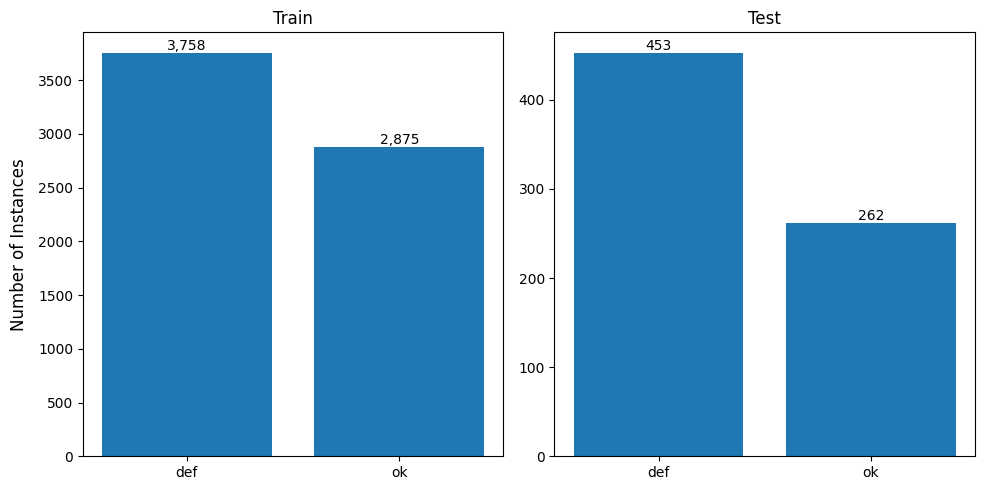

In [7]:
label_names, counts = np.unique(labels_df["Label"].values, return_counts = True)
test_label_names, test_counts = np.unique(test_df["Label"].values, return_counts = True)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.supylabel('Number of Instances')
bar0 = axs[0].bar(label_names, counts)
axs[0].set(title='Train')
axs[0].bar_label(bar0, fmt='{:,.0f}')
bar1 = axs[1].bar(test_label_names, test_counts)
axs[1].set(title='Test')
axs[1].bar_label(bar1, fmt='{:,.0f}')
plt.tight_layout()
plt.show()

train/validation/test splits

In [8]:
split_ratio = .2
total_num_val = int(split_ratio*sum(counts))
print(f"Number Val data: {total_num_val}")
# pos_num_val = int((counts[0]/len(labels_df))*total_num_val)
pos_num_val = int((1/2)*total_num_val)
neg_num_val = total_num_val - pos_num_val
print(f"Number of Val Positive Labels: {pos_num_val}")
print(f"Number of Val Negative Labels: {neg_num_val}")

pos_val_ind = np.random.RandomState(123).randint(0, counts[0], size=pos_num_val)
neg_val_ind = np.random.RandomState(123).randint(0, counts[1], size=neg_num_val)

selected_pos_data = labels_df[labels_df["NumLabel"]==1]["Path"].values[pos_val_ind]
selected_neg_data = labels_df[labels_df["NumLabel"]==0]["Path"].values[neg_val_ind]
selected_data = list(selected_pos_data) + list(selected_neg_data)
labels_df["Split"] = labels_df.apply(lambda x: "validation" if x["Path"] in selected_data else "train", axis=1)
print(labels_df.info())
print(labels_df.head())

Number Val data: 1326
Number of Val Positive Labels: 663
Number of Val Negative Labels: 663
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6633 entries, 0 to 6632
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Path      6633 non-null   object
 1   Label     6633 non-null   object
 2   NumLabel  6633 non-null   int64 
 3   Split     6633 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.4+ KB
None
                                                Path Label  NumLabel  \
0  /kaggle/input/real-life-industrial-dataset-of-...    ok         0   
1  /kaggle/input/real-life-industrial-dataset-of-...    ok         0   
2  /kaggle/input/real-life-industrial-dataset-of-...    ok         0   
3  /kaggle/input/real-life-industrial-dataset-of-...    ok         0   
4  /kaggle/input/real-life-industrial-dataset-of-...    ok         0   

        Split  
0       train  
1  validation  
2       train  
3  validation  
4   

## Data Generator Preparation

In [9]:
from torchvision.io import read_image
from imgaug import augmenters as iaa
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import cv2

class CustomImageDataset(Dataset):
    def __init__(
        self,
        dataset_csv_file,
        x_col,
        y_col,
        class_names,
        source_image_dir,
        batch_size=16,
        target_size=(224, 224),
        add_channel=True,
        crop_ratio=[0, 10],
        augmentation=True,
        verbose=0,
        steps=None,
        random_state=None,
        transform=None,
        target_transform=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.dataset_df = dataset_csv_file
        self.source_image_dir = source_image_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.add_channel = add_channel
        self.crop_ratio = crop_ratio
        self.augmentation = augmentation
        self.verbose = verbose
        self.random_state = random_state
        self.transform = transform
        self.target_transform = target_transform
        self.class_names = class_names
        self.x_col = x_col
        self.y_col = y_col
        self.prepare_dataset()
        if steps is None:
            self.steps = int(np.ceil(len(self.x_path) / float(self.batch_size)))
        else:
            self.steps = int(steps)
            
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])
        if target_transform is None:
            self.target_transform = lambda target: torch.tensor([target]).squeeze()

    def get_dataset_df(self):
        return self.dataset_df

    def __len__(self):
        return len(self.dataset_df)    
    
    def __getitem__(self, idx):
        x = np.asarray(self.load_image(self.x_path[idx]))
        y = self.y[idx]
        if self.augmentation:
            x = self.augment_image(x)
        
        if self.transform:
            x = self.transform(x.copy())

        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y

    def load_image(self, image_file):
        image_array = cv2.imread(image_file, cv2.IMREAD_UNCHANGED).astype('float32')
        w = self.target_size[1]
        h = self.target_size[0]
        image_array = cv2.resize(image_array, (w, h))
        image_array = (image_array - image_array.min()) / (image_array.max()-image_array.min())
        return image_array

    def augment_image(self, inp):
        if self.augmentation:
            sometimes = lambda aug: iaa.Sometimes(0.5, aug)
            augmenter = iaa.Sequential(
                [
                    # iaa.GammaContrast((0.8, 1.2), per_channel=True),
                    iaa.Multiply((0.9, 1.1), per_channel=True),
                    # iaa.Add((-10, 10), per_channel=0.5),
                    iaa.Fliplr(0.50),
                    iaa.LinearContrast((0.4, 1.6)),
                    iaa.Flipud(0.50),
                    sometimes(
                        iaa.Crop(px=(self.crop_ratio[0], self.crop_ratio[1]),
                                 keep_size=True, sample_independently=False)
                    ),
                ],
                random_order=True,
            )
            inp = augmenter.augment_image(inp)
        return inp

    def get_y_true(self):
        if self.shuffle:
            raise ValueError(
                """
            You're trying run get_y_true() when generator option 'shuffle_on_epoch_end' is True.
            """
            )
        return self.y[: self.steps * self.batch_size]

    def get_x_true(self):
        if self.shuffle:
            raise ValueError(
                """
            You're trying run get_y_true() when generator option 'shuffle_on_epoch_end' is True.
            """
            )
        return self.x_path[: self.steps * self.batch_size]

    def prepare_dataset(self):
        # df = self.dataset_df.sample(frac=1.0, random_state=self.random_state)
        df = self.dataset_df
        self.x_path, self.y = (df[self.x_col].values,
                                df[self.y_col].values.astype('float32'))


In [10]:
from sklearn.utils import shuffle

train_df = labels_df[labels_df['Split']=='train']
val_df = labels_df[labels_df['Split']=='validation']

train_df = shuffle(train_df, random_state=123)
val_df = shuffle(val_df, random_state=123)

In [11]:
shuffle = True
if shuffle:
    permutation = np.random.RandomState(123).permutation(len(train_df))
    dataset_csv_file = train_df.iloc[permutation].reset_index(drop=True)
else:
    dataset_csv_file = train_df
image_source_dir = train_dir
target_size = (256, 256)
add_channel = False
class_names = ['ok', 'def']
batch_size = 32
steps = int(np.ceil(len(train_df) / batch_size))
augmentation = True
random_seed=123

x_col = "Path"
y_col = "NumLabel"
train_ds = CustomImageDataset(
            dataset_csv_file=dataset_csv_file,
            x_col=x_col,
            y_col=y_col,
            class_names=class_names,
            source_image_dir=image_source_dir,
            batch_size=batch_size,
            target_size=target_size,
            add_channel = add_channel,
            augmentation=augmentation,
            steps=steps,
            random_state=random_seed,
            )

In [12]:
shuffle = True
if shuffle:
    permutation = np.random.RandomState(123).permutation(len(val_df))
    dataset_csv_file = val_df.iloc[permutation].reset_index(drop=True)
else:
    dataset_csv_file = val_df
image_source_dir = train_dir
target_size = (256, 256)
add_channel = False
class_names = ['ok', 'def']
batch_size = 32
steps = int(np.ceil(len(val_df) / batch_size))
augmentation = False
random_seed=123

x_col = "Path"
y_col = "NumLabel"
val_ds = CustomImageDataset(
            dataset_csv_file=dataset_csv_file,
            x_col=x_col,
            y_col=y_col,
            class_names=class_names,
            source_image_dir=image_source_dir,
            batch_size=batch_size,
            target_size=target_size,
            add_channel = add_channel,
            augmentation=augmentation,
            steps=steps,
            random_state=random_seed,
            )

In [13]:
shuffle = True
if shuffle:
    permutation = np.random.RandomState(123).permutation(len(test_df))
    dataset_csv_file = test_df.iloc[permutation].reset_index(drop=True)
else:
    dataset_csv_file = test_df
image_source_dir = train_dir
target_size = (256, 256)
add_channel = False
class_names = ['ok', 'def']
batch_size = 32
steps = int(np.ceil(len(test_df) / batch_size))
augmentation = False
random_seed=123

x_col = "Path"
y_col = "NumLabel"
test_ds = CustomImageDataset(
            dataset_csv_file = dataset_csv_file,
            x_col = x_col,
            y_col = y_col,
            class_names = class_names,
            source_image_dir = image_source_dir,
            batch_size = batch_size,
            target_size = target_size,
            add_channel = add_channel,
            augmentation = augmentation,
            steps = steps,
            random_state = random_seed,
            )

0 (3, 256, 256)
1 (3, 256, 256)
2 (3, 256, 256)
3 (3, 256, 256)
4 (3, 256, 256)


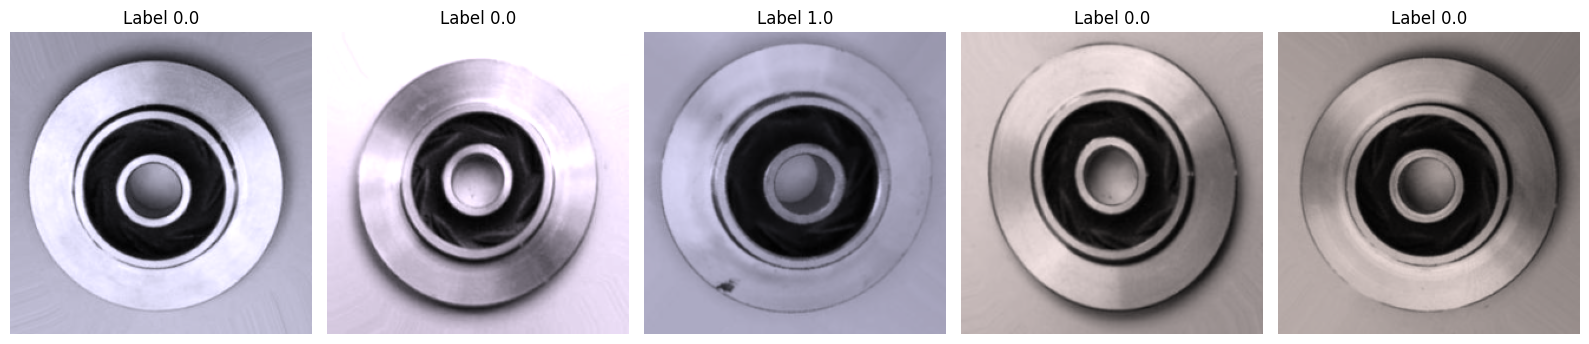

In [14]:
def visualize_samples(dataset, num_samples):
    ds = copy.deepcopy(dataset)
    fig, axs = plt.subplots(1, num_samples)
    fig.set_size_inches(16, 4)
    for i in range(num_samples):
        sample = ds[i]
        img = sample[0].numpy()
        y = sample[1].numpy()
        print(i, img.shape)
        axs[i].set_title(f'Label {y}')
        axs[i].axis('off')
        axs[i].imshow(np.moveaxis(img, 0, -1))

    plt.tight_layout()
    plt.show()
visualize_samples(train_ds, 5)

In [15]:
train_loader = DataLoader(
    train_ds, batch_size=train_ds.batch_size, shuffle=True
)

val_loader = DataLoader(
    val_ds, batch_size=val_ds.batch_size, shuffle=True
)

test_loader = DataLoader(
    test_ds, batch_size=test_ds.batch_size, shuffle=False
)

## Model Creation

In [16]:
from torchvision.models import resnet18
from torch import nn

model = resnet18(weights='IMAGENET1K_V1')
feat_extractor = model.fc.in_features
model.fc = nn.Linear(feat_extractor, 1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

class_weights_ratio = len(train_df[train_df['NumLabel']==0])/len(train_df[train_df['NumLabel']==1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([class_weights_ratio]).to(device))  # binary cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [17]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [18]:
from torcheval.metrics.functional import (binary_accuracy, binary_f1_score,
                                        binary_precision, binary_recall, binary_confusion_matrix)

def report_statistics(y_pred, y_true):
    acc = binary_accuracy(y_pred, y_true)
    precision = binary_precision(y_pred, y_true)
    recall = binary_recall(y_pred, y_true)
    f1 = binary_f1_score(y_pred, y_true)
    cm = binary_confusion_matrix(y_pred, y_true)
    tp, fn = cm[0]
    fp, tn = cm[1]
    
    return {
        "acc": acc,
        "f1": f1, 
        "precision": precision,
        "recall": recall,
        "tp": tp,
        "fn": fn,
        "fp": fp,
        "tn": tn,
    }

## Model Training

In [19]:
n_epochs = 10
best_val_loss = + np.inf 
best_weights = None

acc_list = []
loss_list = []
f1_list = []
val_acc_list = []
val_loss_list = []
val_f1_list = []
for epoch in range(n_epochs):
    model.train()
    with tqdm(train_loader, unit="batch") as bar:
        total_loss = 0.0
        total_corrects = 0
        num_data_visited = 0
        y_preds_total = torch.empty(0, dtype=torch.int).to(device)
        y_true_total = torch.empty(0, dtype=torch.int).to(device)
        for batch in bar:
            bar.set_description(f"Epoch {epoch}")
            # take a batch
            X_batch = batch[0].to(device)
            y_batch = batch[1].to(device)
            num_data_visited += len(X_batch)
            y_logits = model(X_batch).squeeze() # squeeze to remove extra `1` dimensions 
            y_preds = torch.round(torch.sigmoid(y_logits))
            loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                           y_batch) 
            y_preds_total = torch.cat((y_preds_total, y_preds.int()), 0)
            y_true_total = torch.cat((y_true_total, y_batch.int()), 0)
            optimizer.zero_grad()
            
            # backward pass
            loss.backward()
            # update weights
            optimizer.step()
            
            # calculating statistics
            total_loss += loss.item() * X_batch.size(0)
            total_corrects += torch.sum(y_preds == y_batch)
            train_loss = float(total_loss)/num_data_visited
            train_reports = report_statistics(y_preds_total, y_true_total)
            # progress bar
            bar.set_postfix(
                loss=train_loss, acc=float(train_reports['acc']), f1=float(train_reports['f1']),
                recall=float(train_reports['recall']), precision=float(train_reports['precision']),
                tp=int(train_reports['tp']), fn=int(train_reports['fn']), fp=int(train_reports['fp']),
                tn=int(train_reports['tn'])
            )
        loss_list.append(train_loss)
        acc_list.append(float(train_reports['acc']))
        f1_list.append(float(train_reports['f1']))

        # evaluate validation-set at end of each epoch
        model.eval()
        with torch.inference_mode():
            total_val_loss = 0.0
            total_val_corrects = 0
            num_val_data_visited = 0
            y_val_preds_total = torch.empty(0, dtype=torch.int).to(device)
            y_val_true_total = torch.empty(0, dtype=torch.int).to(device)
            for i, batch in enumerate(val_loader):
                X_batch = batch[0].to(device)
                y_batch = batch[1].to(device)
                num_val_data_visited += len(X_batch)
                val_logits = model(X_batch).squeeze() 
                val_preds = torch.round(torch.sigmoid(val_logits))
                val_loss = loss_fn(val_logits,
                                    y_batch)
                total_val_loss += val_loss.item() * X_batch.size(0)
                total_val_corrects += torch.sum(val_preds == y_batch)
                y_val_preds_total = torch.cat((y_val_preds_total, val_preds.int()), 0)
                y_val_true_total = torch.cat((y_val_true_total, y_batch.int()), 0)
            val_loss = float(total_val_loss)/len(val_df)
            val_reports = report_statistics(y_val_preds_total, y_val_true_total)
            val_loss_list.append(val_loss)
            val_acc_list.append(float(val_reports['acc']))
            val_f1_list.append(float(val_reports['f1']))
            
        # print classification report
        report = f"""Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_reports['acc']:.2f}%,
                F1: {train_reports['f1']:.2f}%, Precision: {train_reports['precision']:.2f}%,
                Recall: {train_reports['recall']:.2f}%, TP: {train_reports['tp']}, 
                FN: {train_reports['fn']},FP: {train_reports['fp']}, TN: {train_reports['tn']}, | 
                Val-loss: {val_loss:.5f}, Val-Acc: {val_reports['acc']:.2f}%,
                Val-F1: {val_reports['f1']:.2f}%, Val-Precision: {val_reports['precision']:.2f},
                Val-Recall: {val_reports['recall']:.2f}%, Val-TP: {val_reports['tp']},
                Val-FN: {val_reports['fn']}, Val-FP: {val_reports['fp']}, Val-TN: {val_reports['tn']},
                """.replace("\n", " ").strip()
        print(" ".join(report.split()))
        if val_loss < best_val_loss:
            print(f"val-loss improved from {best_val_loss} to {val_loss}. best model saved.")
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
        else:
            print(f"val-loss didn't improved from {best_val_loss}.")
        
# restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 170/170 [01:06<00:00,  2.56batch/s, acc=0.974, f1=0.977, fn=32, fp=109, loss=0.0586, precision=0.99, recall=0.965, tn=3037, tp=2249]


Epoch: 0 | Loss: 0.05856, Accuracy: 0.97%, F1: 0.98%, Precision: 0.99%, Recall: 0.97%, TP: 2249, FN: 32,FP: 109, TN: 3037, | Val-loss: 0.03150, Val-Acc: 0.99%, Val-F1: 0.99%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 9, Val-TN: 603,
val-loss improved from inf to 0.031498447480684096. best model saved.


Epoch 1: 100%|██████████| 170/170 [00:51<00:00,  3.31batch/s, acc=0.991, f1=0.992, fn=15, fp=34, loss=0.0245, precision=0.995, recall=0.989, tn=3112, tp=2266]


Epoch: 1 | Loss: 0.02445, Accuracy: 0.99%, F1: 0.99%, Precision: 1.00%, Recall: 0.99%, TP: 2266, FN: 15,FP: 34, TN: 3112, | Val-loss: 0.01544, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.031498447480684096 to 0.015440896483293423. best model saved.


Epoch 2: 100%|██████████| 170/170 [00:52<00:00,  3.24batch/s, acc=0.995, f1=0.996, fn=3, fp=23, loss=0.0157, precision=0.999, recall=0.993, tn=3123, tp=2278]


Epoch: 2 | Loss: 0.01566, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 0.99%, TP: 2278, FN: 3,FP: 23, TN: 3123, | Val-loss: 0.01360, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.015440896483293423 to 0.013595219127946591. best model saved.


Epoch 3: 100%|██████████| 170/170 [00:53<00:00,  3.20batch/s, acc=0.997, f1=0.998, fn=1, fp=14, loss=0.0105, precision=1, recall=0.996, tn=3132, tp=2280]


Epoch: 3 | Loss: 0.01053, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 1.00%, TP: 2280, FN: 1,FP: 14, TN: 3132, | Val-loss: 0.01526, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss didn't improved from 0.013595219127946591.


Epoch 4: 100%|██████████| 170/170 [00:52<00:00,  3.23batch/s, acc=0.995, f1=0.996, fn=6, fp=22, loss=0.0121, precision=0.998, recall=0.993, tn=3124, tp=2275]


Epoch: 4 | Loss: 0.01211, Accuracy: 0.99%, F1: 1.00%, Precision: 1.00%, Recall: 0.99%, TP: 2275, FN: 6,FP: 22, TN: 3124, | Val-loss: 0.01344, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.013595219127946591 to 0.013443235623006203. best model saved.


Epoch 5: 100%|██████████| 170/170 [00:53<00:00,  3.17batch/s, acc=0.996, f1=0.997, fn=3, fp=16, loss=0.0107, precision=0.999, recall=0.995, tn=3130, tp=2278]


Epoch: 5 | Loss: 0.01075, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 0.99%, TP: 2278, FN: 3,FP: 16, TN: 3130, | Val-loss: 0.02394, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss didn't improved from 0.013443235623006203.


Epoch 6: 100%|██████████| 170/170 [00:51<00:00,  3.27batch/s, acc=0.997, f1=0.997, fn=1, fp=15, loss=0.00771, precision=1, recall=0.995, tn=3131, tp=2280]


Epoch: 6 | Loss: 0.00771, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 1.00%, TP: 2280, FN: 1,FP: 15, TN: 3131, | Val-loss: 0.01658, Val-Acc: 0.99%, Val-F1: 0.99%, Val-Precision: 0.99, Val-Recall: 0.99%, Val-TP: 588, Val-FN: 6, Val-FP: 5, Val-TN: 607,
val-loss didn't improved from 0.013443235623006203.


Epoch 7: 100%|██████████| 170/170 [00:52<00:00,  3.23batch/s, acc=0.996, f1=0.997, fn=3, fp=16, loss=0.00856, precision=0.999, recall=0.995, tn=3130, tp=2278]


Epoch: 7 | Loss: 0.00856, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 0.99%, TP: 2278, FN: 3,FP: 16, TN: 3130, | Val-loss: 0.01341, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.013443235623006203 to 0.013405325147593595. best model saved.


Epoch 8: 100%|██████████| 170/170 [00:51<00:00,  3.28batch/s, acc=0.995, f1=0.996, fn=6, fp=20, loss=0.0139, precision=0.998, recall=0.994, tn=3126, tp=2275]


Epoch: 8 | Loss: 0.01393, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 0.99%, TP: 2275, FN: 6,FP: 20, TN: 3126, | Val-loss: 0.01184, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.013405325147593595 to 0.011837601636391238. best model saved.


Epoch 9: 100%|██████████| 170/170 [00:52<00:00,  3.27batch/s, acc=0.996, f1=0.997, fn=4, fp=15, loss=0.00976, precision=0.999, recall=0.995, tn=3131, tp=2277]


Epoch: 9 | Loss: 0.00976, Accuracy: 1.00%, F1: 1.00%, Precision: 1.00%, Recall: 1.00%, TP: 2277, FN: 4,FP: 15, TN: 3131, | Val-loss: 0.01150, Val-Acc: 1.00%, Val-F1: 1.00%, Val-Precision: 1.00, Val-Recall: 0.99%, Val-TP: 594, Val-FN: 0, Val-FP: 6, Val-TN: 606,
val-loss improved from 0.011837601636391238 to 0.011495178479953804. best model saved.


<All keys matched successfully>

plotting metrics

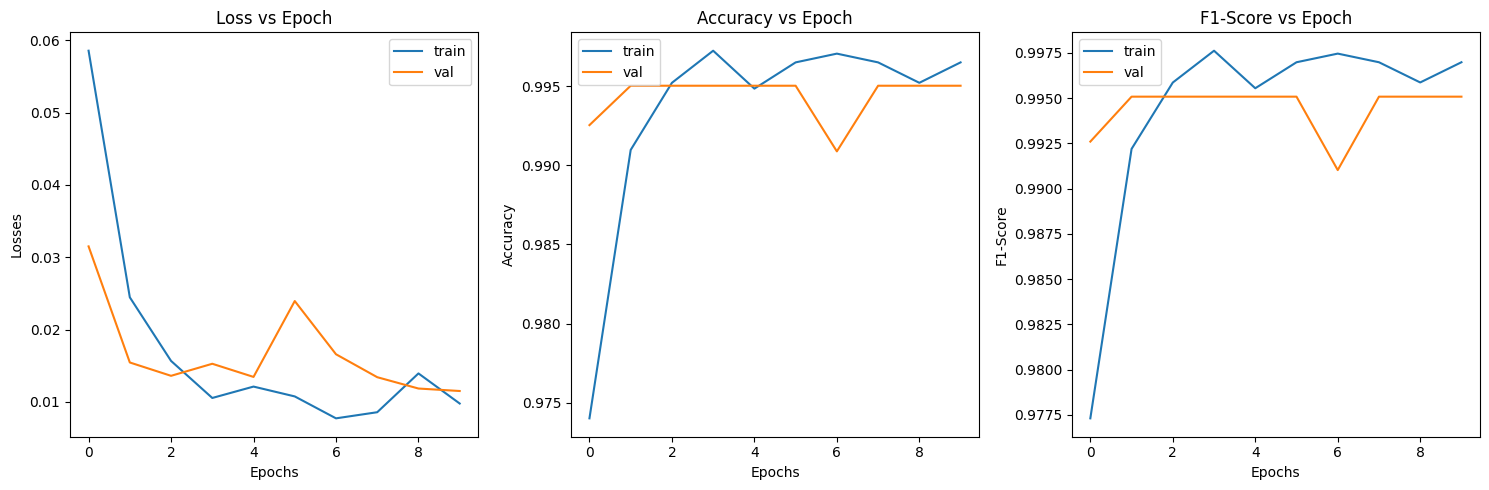

In [20]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax[0].plot(loss_list)
ax[0].plot(val_loss_list)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Losses")
ax[0].set_title("Loss vs Epoch")
ax[0].legend(["train", "val"])

ax[1].plot(acc_list)
ax[1].plot(val_acc_list)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy vs Epoch")
ax[1].legend(["train", "val"])

ax[2].plot(f1_list)
ax[2].plot(val_f1_list)
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("F1-Score")
ax[2].set_title("F1-Score vs Epoch")
ax[2].legend(["train", "val"])

plt.tight_layout()
plt.show()

## Evaluation

In [21]:
model.eval()
with torch.inference_mode():
    y_test_preds_total = torch.empty(0, dtype=torch.int).to(device)
    y_test_true_total = torch.empty(0, dtype=torch.int).to(device)
    for i, batch in enumerate(test_loader):
        X_batch = batch[0].to(device)
        y_batch = batch[1].to(device)
        test_logits = model(X_batch).squeeze() 
        test_preds = torch.round(torch.sigmoid(test_logits))
        y_test_preds_total = torch.cat((y_test_preds_total, test_preds.int()), 0)
        y_test_true_total = torch.cat((y_test_true_total, y_batch.int()), 0)
        
metrics_dict = report_statistics(y_test_preds_total, y_test_true_total)
report = f"""Accuracy: {metrics_dict['acc']:.2f}%, F1-Score: {metrics_dict['f1']:.2f}%
        Precision: {metrics_dict['precision']:.2f}%, Recall: {metrics_dict['recall']:.2f}%,
        TP: {metrics_dict['tp']}, FN: {metrics_dict['fn']}, FP: {metrics_dict['fp']}, TN: {metrics_dict['tn']},
        """.replace("\n", " ").strip()
print(" ".join(report.split()))

Accuracy: 1.00%, F1-Score: 1.00% Precision: 1.00%, Recall: 0.99%, TP: 262, FN: 0, FP: 3, TN: 450,


## Model Explainability

Grad-CAM

0 torch.Size([3, 256, 256])
1 torch.Size([3, 256, 256])
2 torch.Size([3, 256, 256])
3 torch.Size([3, 256, 256])
4 torch.Size([3, 256, 256])


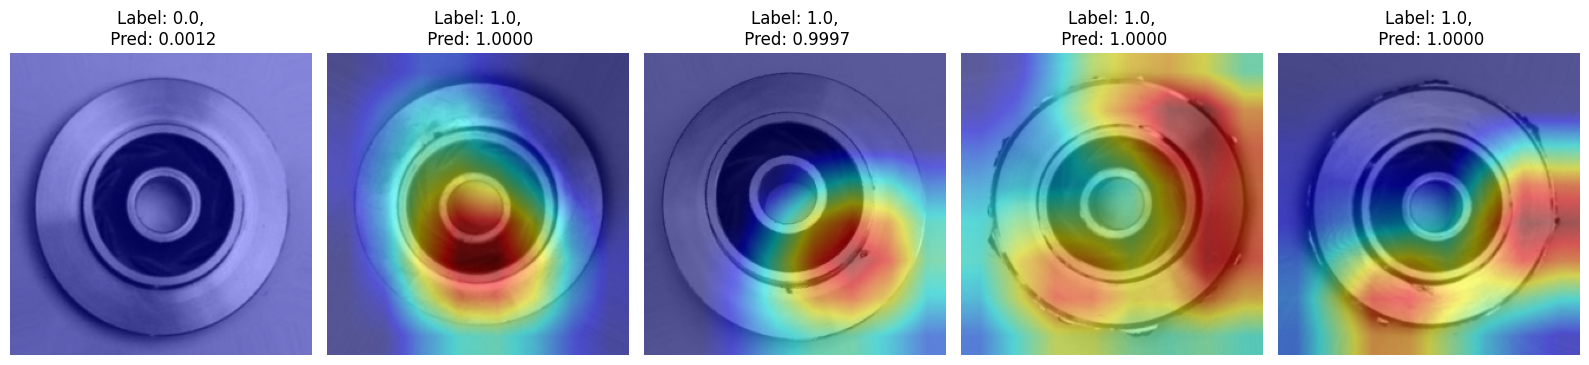

In [22]:
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_grad_cam(model, inp_tensor, traget_layers=None, target_label=0):
    if traget_layers is None:
        target_layers = [model.layer4[-1]]

    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(target_label)]

    grayscale_cam = cam(input_tensor=inp_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]
    rgb_img = np.moveaxis(inp_tensor[0].numpy(), 0, -1)
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization 

def predict(model, inp):
    model.eval();
    inp = inp.to(device)
    with torch.no_grad():
        logit = model(inp)
        prob = torch.sigmoid(logit)
        pred = torch.round(prob)
    return prob.detach().cpu().numpy()
    
def visualize_cam(inp_batch, num_samples):
    fig, axs = plt.subplots(1, num_samples)
    fig.set_size_inches(16, 4)
    for i in range(num_samples):
        img = inp_batch[0][i]
        y = inp_batch[1][i]
        pred = predict(model, img[None, ])[0][0]
        grad_cam_tensor = get_grad_cam(model, img[None, ])
        print(i, img.shape)
        axs[i].set_title(f'Label: {y.numpy()},\n Pred: {pred:.4f}')
        axs[i].axis('off')
        axs[i].imshow(grad_cam_tensor)

    plt.tight_layout()
    plt.show()
    
input_batch = next(iter(test_loader))
visualize_cam(input_batch, num_samples=5)